In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(1)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetAltura/train
# !mkdir ../datasetAltura/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetAltura'),
#                 image.replace('datasetClean','../datasetAltura/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=224,size=224):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_masa,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetAltura2/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=16)

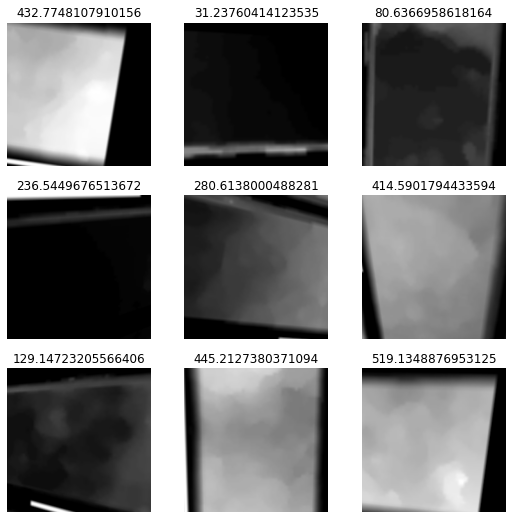

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='resnetrs50Masav2Height')
]

In [17]:
from fastai.metrics import mae,rmse,mse

In [18]:
learn = Learner(dls, timm.create_model('resnetrs50',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,109250.679688,124198.070312,281.903564,352.417450,124198.070312,00:04


Better model found at epoch 0 with valid_loss value: 124198.0703125.


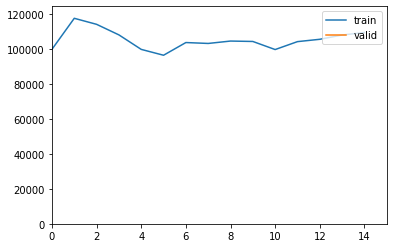

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,108629.664062,123800.359375,282.163208,351.852753,123800.359375,00:03
1,106809.703125,105555.437500,263.716705,324.892975,105555.437500,00:03
2,104986.148438,92565.085938,250.571381,304.245148,92565.085938,00:03
3,102393.773438,87333.179688,244.511597,295.521851,87333.179688,00:03
4,99499.929688,67178.750000,219.008530,259.188660,67178.750000,00:03
5,96019.179688,81257.335938,238.195145,285.056702,81257.335938,00:03
6,93247.984375,72616.632812,227.169693,269.474762,72616.632812,00:03
7,89844.414062,71550.390625,225.545502,267.489044,71550.390625,00:03
8,87073.695312,64495.097656,215.345734,253.958847,64495.097656,00:03
9,84600.492188,72644.515625,227.511612,269.526459,72644.515625,00:03


Better model found at epoch 0 with valid_loss value: 123800.359375.


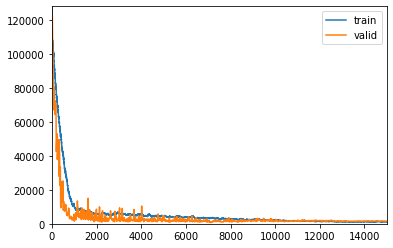

Better model found at epoch 1 with valid_loss value: 105555.4375.
Better model found at epoch 2 with valid_loss value: 92565.0859375.
Better model found at epoch 3 with valid_loss value: 87333.1796875.
Better model found at epoch 4 with valid_loss value: 67178.75.
Better model found at epoch 8 with valid_loss value: 64495.09765625.
Better model found at epoch 12 with valid_loss value: 42657.90234375.
Better model found at epoch 15 with valid_loss value: 38009.41796875.
Better model found at epoch 20 with valid_loss value: 28049.25.
Better model found at epoch 23 with valid_loss value: 22727.755859375.
Better model found at epoch 25 with valid_loss value: 11128.4423828125.
Better model found at epoch 26 with valid_loss value: 9484.751953125.
Better model found at epoch 33 with valid_loss value: 8054.50830078125.
Better model found at epoch 37 with valid_loss value: 7438.99267578125.
Better model found at epoch 43 with valid_loss value: 5047.31103515625.
Better model found at epoch 45 wi

In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [21]:
learn.load('resnetrs50Masav2Height')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [22]:
# df[df['image_id']=='datasetClean/br_2022-01-07T10-54-11.tif']

In [23]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [31]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_masa,
                 item_tfms = Resize(224),
                 batch_tfms=[*aug_transforms(size=224,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [32]:
dlstest = dbtest.dataloaders(path,bs=16)

In [33]:
learn.dls=dlstest

In [34]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 21.935394287109375.


(#4) [876.62890625,21.935394287109375,29.607919692993164,876.62890625]

In [35]:
from sklearn.metrics import mean_absolute_error

In [36]:
preds,gt = learn.tta()

In [37]:
mean_absolute_error(gt,preds)

28.798002